## Importing Libraries

In [1]:
import torch

import torch.nn as nn

import torch.optim as optim

import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset

import numpy as np

from scipy.ndimage import gaussian_filter

from scipy.spatial import distance_matrix

import networkx as nx

import cv2

import json

import matplotlib.pyplot as plt

import os

from tqdm.auto import tqdm


# Utils for data processing
def load_annotation(json_file):

    """Load JSON annotation for a vine image."""

    with open(json_file, 'r') as f:

        annotation = json.load(f)

    return annotation



def parse_features(annotation):
    """Extract vine features (nodes and branch labels) from the annotation JSON."""
    # Access the 'VineImage' list, and then the 'VineFeature' inside it
    vine_images = annotation.get('VineImage', None)
    
    if vine_images is None or len(vine_images) == 0:
        raise KeyError("'VineImage' key not found or empty in the JSON file. Check the JSON structure.")
    
    # Assuming we are dealing with the first image in the list
    features = vine_images[0].get('VineFeature', None)
    
    if features is None:
        raise KeyError("'VineFeature' key not found in the JSON file under 'VineImage'. Check the JSON structure.")
    
    nodes = []
    branches = []
    
    # The VineFeature is a list of lists, so we need to iterate over each inner list
    for feature_list in features:
        for feature in feature_list:
            # Check for 'FeatureType' and other keys
            if 'FeatureType' in feature and feature['FeatureType'] and 'ParentID' in feature and feature['BranchLabel']:
                    branch = 'mainTrunk' if feature['BranchLabel'] == 'root' else feature['BranchLabel']
                    branches.append({
                        'parent_id': feature['ParentID'],
                        'child_id': feature['FeatureID'],
                        'branch_label': branch
                    })
                    nodes.append({
                        'id': feature['FeatureID'],
                        'coordinates': feature['FeatureCoordinates'],
                        'type': feature['FeatureType'],
                        'branch_label': branch
                    })
    return nodes, branches

In [2]:
def generate_vector_field(image_size, branches, limb_width):
    """
    Generate vector fields for branches using point-to-segment distance with optimizations.

    Args:
        image_size (tuple): The size of the vector field (height, width).
        branches (list): List of branch segments, each defined by two nodes [(x1, y1), (x2, y2)].
        limb_width (float): The width of the vector field region.

    Returns:
        numpy.ndarray: Vector field of size (256, 256, 2) with x and y components.
    """
    height, width = image_size
    field_size = 256  # Target resolution for the vector field
    vector_field = np.zeros((field_size, field_size, 2), dtype=np.float32)

    for (x1, y1), (x2, y2) in branches:
        # Scale branch coordinates to field resolution
        x1_scaled = x1 / width * field_size
        y1_scaled = y1 / height * field_size
        x2_scaled = x2 / width * field_size
        y2_scaled = y2 / height * field_size

        # Calculate unit vector direction
        dx, dy = x2_scaled - x1_scaled, y2_scaled - y1_scaled
        segment_length_squared = dx ** 2 + dy ** 2
        if segment_length_squared == 0:
            continue
        unit_vector = (dx / np.sqrt(segment_length_squared), dy / np.sqrt(segment_length_squared))

        # Define the bounding box around the segment
        x_min = max(0, int(min(x1_scaled, x2_scaled) - limb_width))
        x_max = min(field_size, int(max(x1_scaled, x2_scaled) + limb_width))
        y_min = max(0, int(min(y1_scaled, y2_scaled) - limb_width))
        y_max = min(field_size, int(max(y1_scaled, y2_scaled) + limb_width))

        # Create grids for the bounding box
        x_grid, y_grid = np.meshgrid(np.arange(x_min, x_max), np.arange(y_min, y_max))

        # Calculate the parameter t for the projection
        t = ((x_grid - x1_scaled) * dx + (y_grid - y1_scaled) * dy) / segment_length_squared

        # Clamp t to the range [0, 1]
        t_clamped = np.clip(t, 0, 1)

        # Compute the closest points on the segment
        closest_x = x1_scaled + t_clamped * dx
        closest_y = y1_scaled + t_clamped * dy

        # Compute the distance from each point in the grid to the segment
        distances = np.sqrt((x_grid - closest_x) ** 2 + (y_grid - closest_y) ** 2)

        # Find points within the limb width and assign vector values
        mask = distances <= limb_width
        vector_field[y_min:y_max, x_min:x_max, 0][mask] = unit_vector[0]
        vector_field[y_min:y_max, x_min:x_max, 1][mask] = unit_vector[1]

    return vector_field

In [3]:
def get_couples(branches_k, nodes_k):
    couples = {
        'mainTrunk': list(),
        'courson': list(),
        'cane': list(),
        'shoot': list(),
        'lateralShoot': list()
    }
    
    for b in branches_k:
    
        parent_node = next((node for node in nodes_k if node['id'] == b['parent_id']), None)
        child_node = next((node for node in nodes_k if node['id'] == b['child_id']), None)
        if parent_node is None or child_node is None:
            continue
        tuple = (parent_node['coordinates'], child_node['coordinates'])
    
        if b['branch_label'] not in couples.keys():
            continue
    
        couples[b['branch_label']].append(tuple)

    return couples


def get_vector_fields(nodes_j, branches_j):
    
    couples = get_couples(branches_j, nodes_j)
    
    vector_fields = dict()

    for k, c in couples.items():
        limb_width = 3
        vector_field = generate_vector_field((3024, 4032), c, limb_width)
        vector_fields[k] = vector_field

    return vector_fields

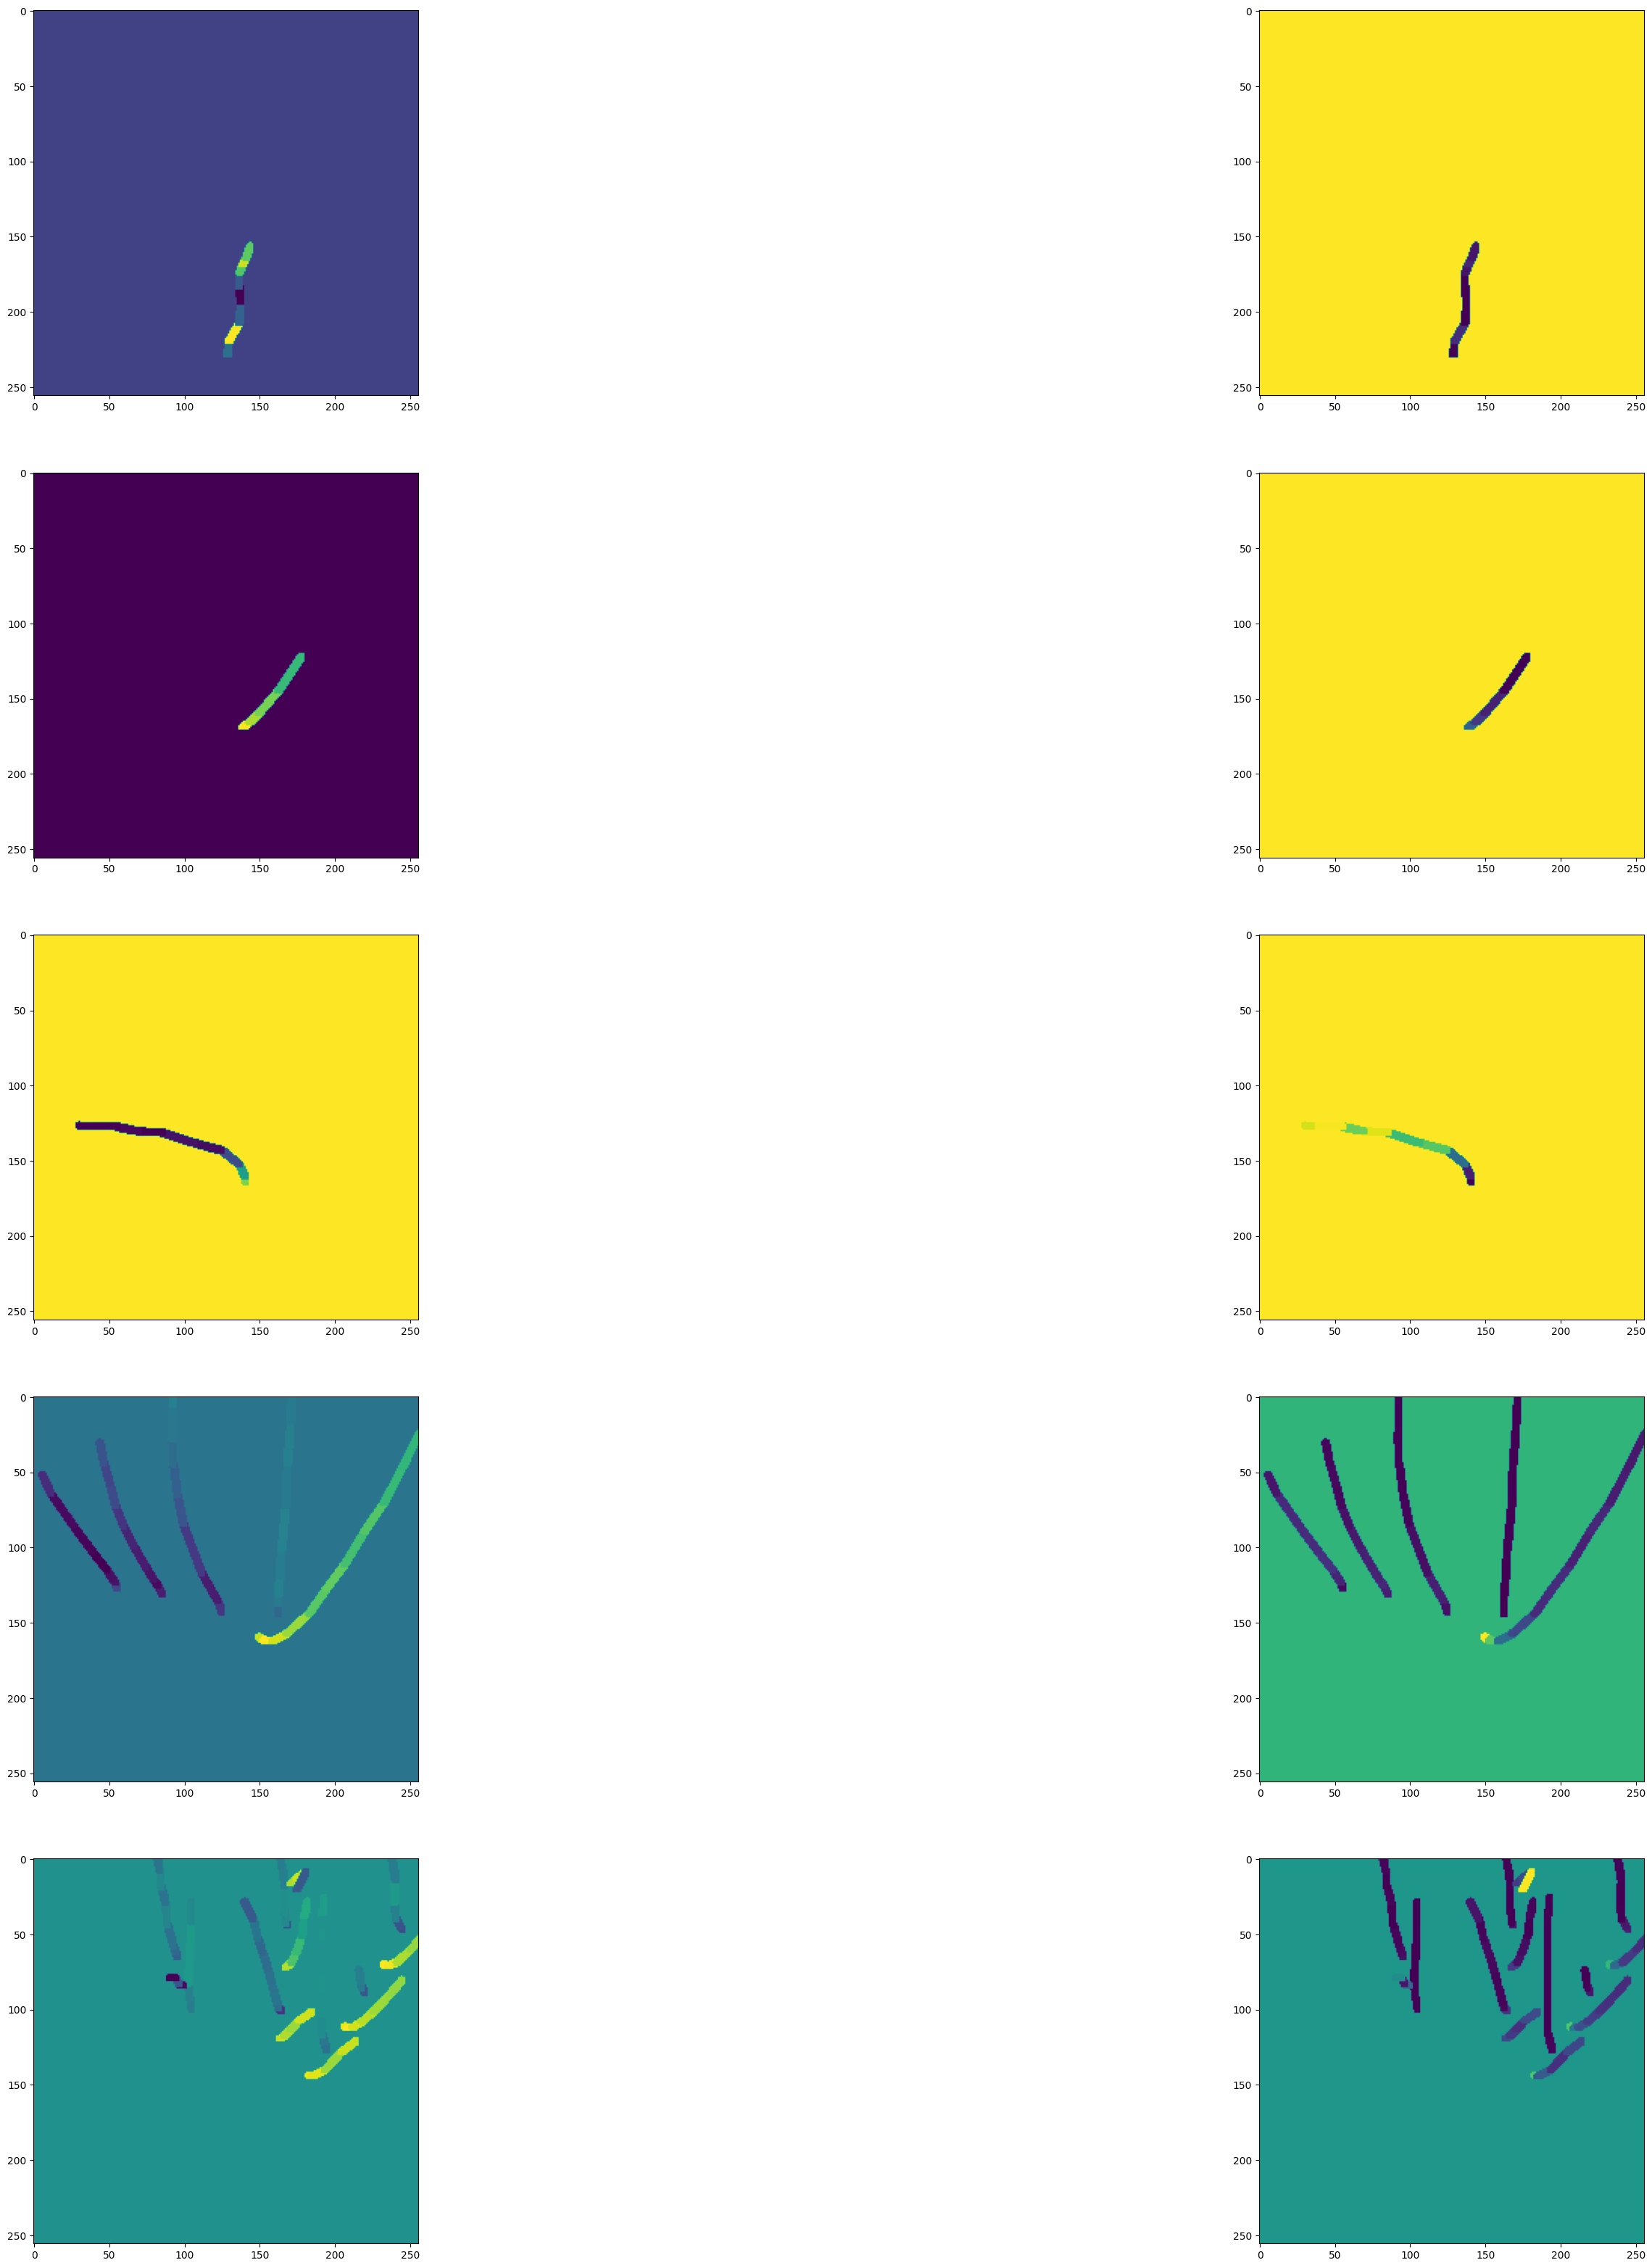

In [4]:
nodes, branches = parse_features(load_annotation('/kaggle/input/vinetdataset/3D2cut_Single_Guyot/01-TrainAndValidationSet/Set00_IMG_3285_annotation.json'))

# Create a row of 3 subplots
fig, axes = plt.subplots(5, 2, figsize=(40, 40))  # 1 row, 3 columns


vector_fields = get_vector_fields(nodes, branches)

i=0
for vector_field in vector_fields.values():
    # Visualize the x and y components of the vector field
    axes[i, 0].imshow(vector_field[:, :, 0]) # plotting X
    axes[i, 1].imshow(vector_field[:, :, 1]) # plotting Y
    i +=1

In [5]:
def generate_node_heatmaps(image_size, nodes, sigma, num_node_types, num_branch_types, new_size=256):
    """
    Generate heatmaps for each node type and branch type with optimized performance.

    Args:
        image_size (tuple): Original size of the image (H, W).
        nodes (list): List of node coordinates, node types, and branch types [((x, y), node_type, branch_type), ...].
        sigma (float): Gaussian spread for the heatmap.
        num_node_types (int): Total number of node types.
        num_branch_types (int): Total number of branch types.
        new_size (int): Target resolution for heatmaps.

    Returns:
        numpy.ndarray: Heatmaps of shape (num_branch_types, num_node_types, new_size, new_size).
    """
    height, width = image_size
    heatmaps = np.zeros((num_branch_types, num_node_types, new_size, new_size), dtype=np.float32)
    scaling_factor_x = new_size / width
    scaling_factor_y = new_size / height

    for (x, y), node_type, branch_type in nodes:
        # Scale node coordinates to new resolution
        x_scaled = int(x * scaling_factor_x)
        y_scaled = int(y * scaling_factor_y)

        # Define a bounding box around the node
        x_min = max(0, int(x_scaled - 3 * sigma))
        x_max = min(new_size, int(x_scaled + 3 * sigma))
        y_min = max(0, int(y_scaled - 3 * sigma))
        y_max = min(new_size, int(y_scaled + 3 * sigma))

        # Generate Gaussian within the bounding box
        x_range = np.arange(x_min, x_max)
        y_range = np.arange(y_min, y_max)
        x_grid, y_grid = np.meshgrid(x_range, y_range)

        heatmap_patch = np.exp(-((x_grid - x_scaled) ** 2 + (y_grid - y_scaled) ** 2) / (2 * sigma ** 2))
        heatmaps[branch_type, node_type, y_min:y_max, x_min:x_max] += heatmap_patch

    # Clip to [0, 1] for visualization
    np.clip(heatmaps, 0, 1, out=heatmaps)
    return heatmaps

In [6]:
node_types = {
    'rootCrown': 0,
    'branchNode': 1,
    'growingTip': 2,
    'pruningCut': 3
}

branch_types = {
    'mainTrunk': 0,
    'courson': 1,
    'cane': 2,
    'shoot': 3,
    'lateralShoot': 4
}

In [7]:
def convert_nodes(nodes, branches, branch_types, node_types):
    
    new_nodes = list()
    
    for n in nodes:
        if n['type'] not in node_types.keys() or n['branch_label'] not in branch_types.keys():
            continue
        new_nodes.append((n['coordinates'], node_types[n['type']], branch_types[n['branch_label']]))

    return new_nodes

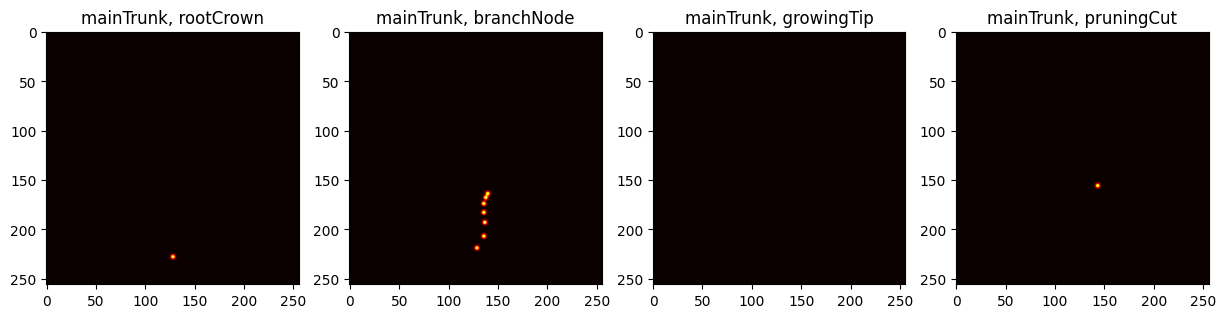

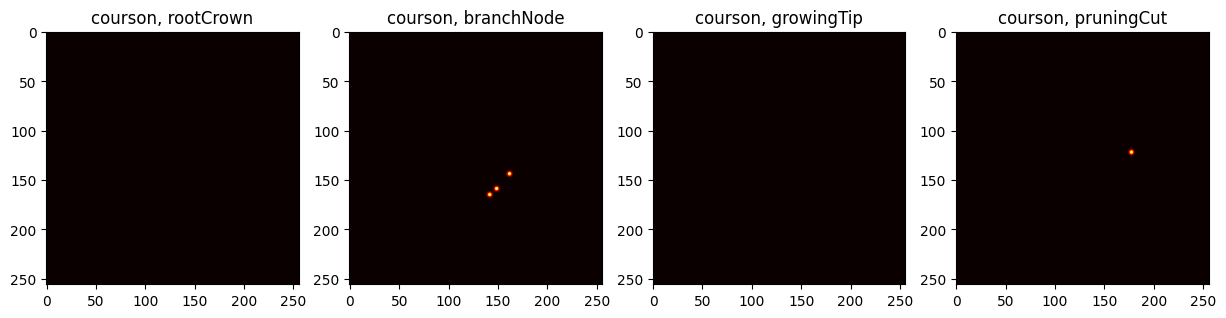

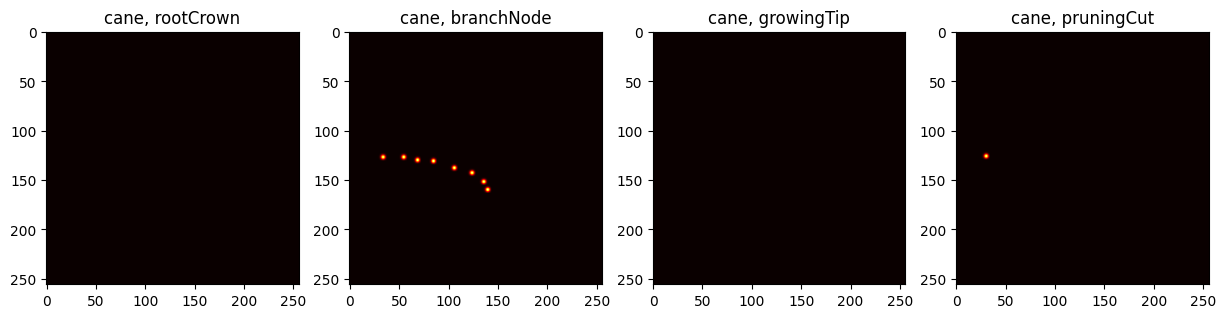

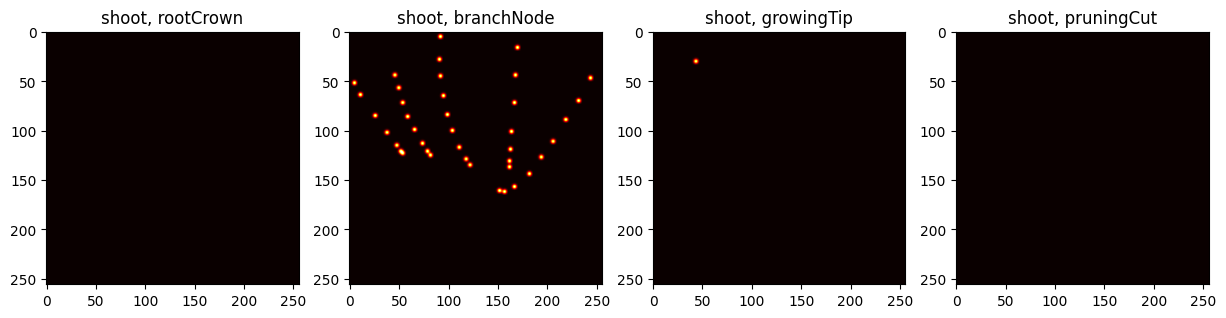

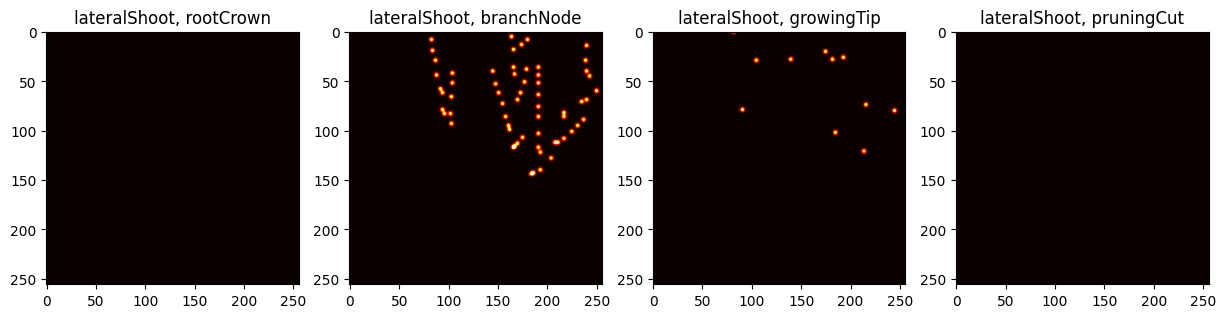

In [8]:
nodes, branches = parse_features(load_annotation('/kaggle/input/vinetdataset/3D2cut_Single_Guyot/01-TrainAndValidationSet/Set00_IMG_3285_annotation.json'))

new_nodes = convert_nodes(nodes, branches, branch_types, node_types)

# print(new_nodes)

num_node_types = 4
num_branch_types = 5
sigma = 1.5
heatmaps = generate_node_heatmaps((3024, 4032), new_nodes, sigma, num_node_types, num_branch_types)

for bname, branch_type in branch_types.items():
    # Visualize heatmaps for branch type 0 and all node types
    fig, axes = plt.subplots(1, num_node_types, figsize=(15, 5))
    for nname, node_type in node_types.items():
        axes[node_type].imshow(heatmaps[branch_type, node_type], cmap='hot')
        axes[node_type].set_title(f"{bname}, {nname}")
    plt.show()

{('mainTrunk', 'rootCrown'): [(128, 228)], ('mainTrunk', 'branchNode'): [(140, 164), (138, 168), (136, 174), (136, 183), (137, 193), (136, 207), (129, 219)], ('mainTrunk', 'growingTip'): [], ('mainTrunk', 'pruningCut'): [(143, 156)], ('courson', 'rootCrown'): [], ('courson', 'branchNode'): [(162, 144), (149, 159), (142, 165)], ('courson', 'growingTip'): [], ('courson', 'pruningCut'): [(177, 122)], ('cane', 'rootCrown'): [], ('cane', 'branchNode'): [(34, 127), (55, 127), (69, 130), (85, 131), (106, 138), (124, 143), (136, 152), (140, 160)], ('cane', 'growingTip'): [], ('cane', 'pruningCut'): [(30, 126)], ('shoot', 'rootCrown'): [], ('shoot', 'branchNode'): [(92, 5), (170, 16), (91, 28), (46, 44), (168, 44), (92, 45), (244, 47), (5, 52), (50, 57), (11, 64), (95, 65), (232, 70), (54, 72), (167, 72), (99, 84), (26, 85), (59, 86), (219, 89), (66, 99), (104, 100), (164, 101), (38, 102), (206, 111), (74, 113), (48, 115), (111, 117), (163, 119), (53, 122), (79, 121), (82, 125), (194, 127), (11

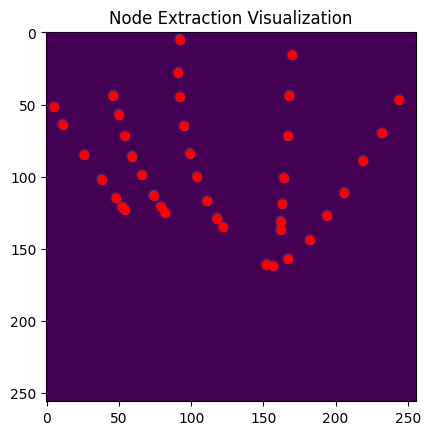

In [9]:
import numpy as np
import cv2
from scipy.ndimage import maximum_filter, label, center_of_mass

def extract_node_coordinates(prediction_map, tau_n=0.5, tau_m=0.97, alpha_lm=0.1):
    """
    Extracts 2D coordinates of nodes from the predicted heatmap.
    
    Args:
        prediction_map (numpy.ndarray): Predicted heatmap of shape (H, W).
        tau_n (float): Threshold for filtering low-confidence predictions.
        tau_m (float): Threshold for local maxima detection.
        alpha_lm (float): Factor for the local maxima neighborhood distance.
    
    Returns:
        coordinates (list of tuples): List of (x, y) coordinates of detected nodes.
    """
    H, W = prediction_map.shape
    d = int(alpha_lm * W)  # Distance for local maxima neighborhood

    # Step 1: Compute local maximum map
    local_max = maximum_filter(prediction_map, size=d, mode='constant')
    local_max_map = np.where(prediction_map >= local_max, prediction_map, 0)

    # Step 2: Apply normalization
    local_max_map = np.where(prediction_map >= tau_n, local_max_map, 0)
    normalized_map = np.divide(local_max_map, np.max(local_max_map), where=local_max_map > 0)

    # Step 3: Thresholding for binary map
    binary_map = (normalized_map >= tau_m).astype(np.uint8)

    # Step 4: Connected component analysis
    labeled_map, num_features = label(binary_map)
    coordinates = []
    for i in range(1, num_features + 1):
        # Find the center of each connected component
        coords = center_of_mass(binary_map, labeled_map, i)
        # print(coords)
        coordinates.append((int(coords[1]), int(coords[0])))  # (x, y) format

    return coordinates


total_nodes_extracted = dict()
for bname, branch_type in branch_types.items():
    # Visualize heatmaps for branch type 0 and all node types
    for nname, node_type in node_types.items():
        # Extract nodes
        heatmap = heatmaps[branch_type, node_type]
        nodes_extracted = extract_node_coordinates(heatmap)
        total_nodes_extracted[(bname, nname)] = nodes_extracted

print(total_nodes_extracted)


heatmap = heatmaps[3,1]
# Visualize
plt.imshow(heatmap)
for n in nodes:
    if n['type'] == 'branchNode' and n['branch_label'] == 'shoot':
        x,y = n['coordinates']
        scaling_factor_x = 256 / 4032
        scaling_factor_y = 256 / 3024

        x_scaled = int(x * scaling_factor_x)
        y_scaled = int(y * scaling_factor_y)
        
        plt.scatter(x_scaled, y_scaled, color='red')

for x, y in nodes_extracted:
    plt.scatter(x, y, color='blue', s=5)
plt.title("Node Extraction Visualization")
plt.show()

calculating mean squared error

In [10]:
possible_parents = {
    'lateralShoot': ["lateralShoot", "shoot"],
    'shoot': ["shoot", "cane", "courson"],
    'cane': ["cane", "mainTrunk"],
    'courson': ["courson", "mainTrunk"],
    'mainTrunk': ["mainTrunk", "rootCrown"]
}

In [11]:
import networkx as nx
import cv2
from scipy.spatial import distance

def calculate_resistivity(child, parent, vector_field):
    """
    Calculate resistivity between two nodes based on alignment with the vector field.
    
    Args:
        child (tuple): Coordinates of the child node (x, y).
        parent (tuple): Coordinates of the parent node (x, y).
        vector_field (numpy.ndarray): Vector field for the node type.
        
    Returns:
        float: Resistivity value for the edge between child and parent.
    """
    v_cp = np.array(child) - np.array(parent)  # Child-to-parent vector
    v_cp_norm = v_cp / (np.linalg.norm(v_cp)+1e-15)  # Normalize the vector
    
    # Interpolate points along the child-parent vector
    n_samples = 100  # Number of samples for integration approximation
    samples = np.linspace(0, 1, n_samples)
    alignments = []
    for u in samples:
        point = (1 - u) * np.array(child) + u * np.array(parent)
        y, x = int(round(point[1])), int(round(point[0]))  # Convert to integer indices
        if 0 <= y < vector_field.shape[0] and 0 <= x < vector_field.shape[1]:
            v_field = vector_field[y, x]
            alignments.append(np.dot(v_cp_norm, v_field))
    A = np.mean(alignments)  # Average alignment score

    resistivity = (1 - A) * np.linalg.norm(v_cp)  # Calculate resistivity
    return resistivity

def construct_resistivity_graph(nodes_by_type, vector_fields, possible_parents, radius=0.2* 256):
    """
    Construct the resistivity graph for the grapevine structure.
    
    Args:
        nodes_by_type (dict): Dictionary of nodes categorized by (type, subtype).
        vector_fields (dict): Vector fields for each node type.
        possible_parents (dict): Dictionary of allowed parent types for each node type.
        radius (float): Maximum distance for potential parent nodes.
    
    Returns:
        nx.DiGraph: Resistivity graph with weights representing resistivity.
    """
    G = nx.DiGraph()

    # Flatten all nodes into a single list with type info
    all_nodes = []
    for node_type, nodes in nodes_by_type.items():
        for node in nodes:
            all_nodes.append((node, node_type))
    all_nodes = set(all_nodes)  # Remove duplicates

    # Add nodes to the graph
    for node, node_type in all_nodes:
        # print(node, node_type)
        G.add_node((node, node_type))

    # Add edges with resistivity weights
    for child, child_type in all_nodes:
        for parent, parent_type in all_nodes:
            if child == parent:
                continue
            if parent_type[0] in possible_parents.get(child_type[0], []):
                dist = distance.euclidean(child, parent)
                if dist <= radius:
                    resistivity = calculate_resistivity(child, parent, vector_fields[parent_type[0]]) + calculate_resistivity(child, parent, vector_fields[child_type[0]])
                    G.add_edge((child, child_type), (parent, parent_type), weight=resistivity)    

        # Relaxation: If no compatible parent is found, use the closest compatible node
        compatible_parents = [
            (parent, parent_type)
            for parent, parent_type in all_nodes
            if parent_type[0] in possible_parents.get(child_type[0], [])
        ]
        if not compatible_parents:
            continue
        closest_parent = min(compatible_parents, key=lambda p: distance.euclidean(child, p[0]))
        resistivity = calculate_resistivity(child, closest_parent[0], vector_fields[closest_parent[1][0]])
        G.add_edge((child, child_type), closest_parent, weight=resistivity)

    return G

def grapevine_structure_estimation(graph, root_node):
    """
    Estimate the tree structure using shortest paths from all nodes to the root node,
    including edge resistivity weights.

    Args:
        graph (nx.DiGraph): Resistivity graph.
        root_node (tuple): The root node (coordinates, type).

    Returns:
        nx.DiGraph: Tree structure as a directed graph with edge weights.
    """
    tree = nx.DiGraph()

    # Add nodes and edges to the tree with weights
    for node in graph.nodes:
        if node != root_node:
            try:
                path = nx.shortest_path(graph, source=node, target=root_node, weight="weight")
                # Add edges from the path (child -> parent)
                for i in range(len(path) - 1):
                    child = path[i]
                    parent = path[i + 1]
                    weight = graph[child][parent]["weight"]  # Get resistivity weight
                    tree.add_edge(child, parent, weight=weight)
            except nx.NetworkXNoPath:
                pass  # Skip if no path exists

    return tree


def plot_graph_on_image(graph, image_path=None, image=None, draw_resistivity=True):
    """
    Plot the resistivity graph on top of the original image.
    
    Args:
        graph (nx.DiGraph): The resistivity graph.
        image_path (str): Path to the original image.
    """
    # Load the image
    if image_path:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
    elif image is None:
        raise Exception('Image is None')

    # Prepare node positions
    pos = {}
    for (node, node_type) in graph.nodes:
        pos[(node, node_type)] = (node[0], node[1])  # (x, y) format

    
    # Define a color mapping for nodes based on their main type.
    node_color_map = {
        'mainTrunk': 'red',
        'courson': 'blue',
        'cane': 'green',
        'lateralShoot': 'orange',
        'shoot': 'magenta',
        'rootCrown': 'black'
    }
    
    # Create a list of colors for nodes based on their type.
    node_colors = []
    for (node, node_type) in graph.nodes:
        # Use the first element of the node_type tuple to determine color.
        main_type = node_type[0]
        if node_type[1] == 'rootCrown':
            main_type = 'rootCrown'
        node_colors.append(node_color_map.get(main_type, 'gray'))
    
    # Prepare edge colors: assign color based on the parent's (target's) main type.
    edge_colors = []
    for (u, v) in graph.edges:
        parent_main_type = v[1][0]
        edge_colors.append(node_color_map.get(parent_main_type, 'gray'))
    
    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image, alpha=0.3)
    plt.axis("off")
    
    # Draw nodes
    nx.draw_networkx_nodes(
        graph,
        pos,
        node_size=50,
        node_color=node_colors,
        alpha=0.9
    )
    
    # Draw edges with assigned colors
    nx.draw_networkx_edges(
        graph,
        pos,
        edge_color=edge_colors,
        alpha=0.7,
        arrows=True
    )

    if draw_resistivity:
        edge_labels = nx.get_edge_attributes(graph, "weight")
        formatted_labels = {edge: f"{weight:.2f}" for edge, weight in edge_labels.items()}
        nx.draw_networkx_edge_labels(
            graph,
            pos,
            edge_labels=formatted_labels,
            font_size=8,
            font_color="green",
        )

    # Show the plot
    plt.title("Resistivity Graph Overlay on Original Image")
    plt.show()

{('mainTrunk', 'rootCrown'): [(141, 252)], ('mainTrunk', 'branchNode'): [(167, 152), (163, 162), (161, 170), (156, 186), (156, 194), (155, 211), (151, 227), (140, 237), (136, 241)], ('mainTrunk', 'growingTip'): [], ('mainTrunk', 'pruningCut'): [(168, 149)], ('courson', 'rootCrown'): [], ('courson', 'branchNode'): [(170, 158), (166, 160)], ('courson', 'growingTip'): [], ('courson', 'pruningCut'): [(174, 154)], ('cane', 'rootCrown'): [], ('cane', 'branchNode'): [(45, 110), (8, 112), (24, 112), (67, 115), (89, 118), (109, 126), (121, 135), (129, 147), (146, 161), (150, 169), (154, 174)], ('cane', 'growingTip'): [], ('cane', 'pruningCut'): [(119, 148), (154, 167)], ('shoot', 'rootCrown'): [], ('shoot', 'branchNode'): [(27, 3), (112, 17), (23, 20), (187, 26), (201, 32), (107, 34), (21, 40), (170, 44), (104, 48), (198, 52), (18, 55), (157, 56), (101, 63), (142, 64), (118, 66), (127, 67), (196, 70), (22, 71), (98, 76), (30, 86), (110, 89), (96, 90), (190, 91), (249, 98), (37, 99), (93, 103), 

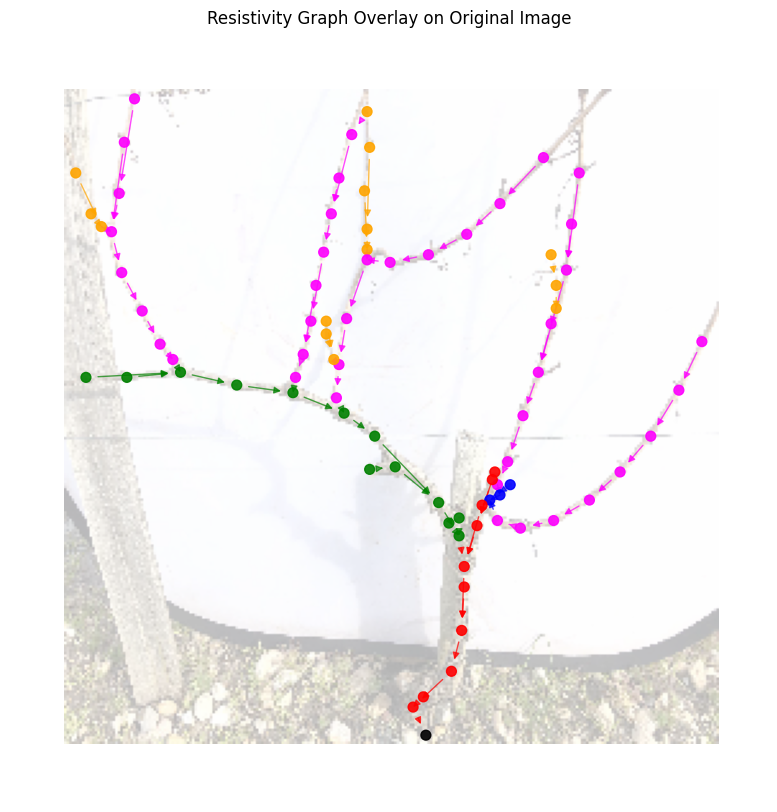

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
num_node_types = 4
num_branch_types = 5
sigma = 1.5

annotation = load_annotation('/kaggle/input/vinetdataset/3D2cut_Single_Guyot/01-TrainAndValidationSet/Set03_IMG_1550_annotation.json')

nodes, branches = parse_features(annotation)

vector_fields = get_vector_fields(nodes, branches)
        
new_nodes = convert_nodes(nodes, branches, branch_types, node_types)
        
# Generate heatmaps for nodes
heatmaps = generate_node_heatmaps((3024, 4032), new_nodes, sigma, num_node_types, num_branch_types)

total_nodes_extracted = dict()
for bname, branch_type in branch_types.items():
    # Visualize heatmaps for branch type 0 and all node types
    for nname, node_type in node_types.items():
        # Extract nodes
        heatmap = heatmaps[branch_type, node_type]
        nodes_extracted = extract_node_coordinates(heatmap)
        total_nodes_extracted[(bname, nname)] = nodes_extracted

print(total_nodes_extracted)

# Construct the resistivity graph
graph = construct_resistivity_graph(total_nodes_extracted, vector_fields, possible_parents, np.inf)

root_node_cohord = total_nodes_extracted[('mainTrunk', 'rootCrown')][0]
root_node = (root_node_cohord, ('mainTrunk', 'rootCrown'))

# Estimate the tree structure
tree_structure = grapevine_structure_estimation(graph, root_node)

# # Print tree structure
# print("Tree structure (child -> parent):")
# for child, parent in tree_structure:
#     print(f"{child} -> {parent}")


plot_graph_on_image(tree_structure, image_path='/kaggle/input/vinetdataset/3D2cut_Single_Guyot/01-TrainAndValidationSet/Set03_IMG_1550.jpg', draw_resistivity=False)
plt.figure()

## Create Training resources

In [61]:
class VineDataset(Dataset):

    """Custom dataset for vine images and annotations stored in the same folder."""

    def __init__(self, data_dir, branch_types, node_types, height=256, width=256, num_node_types=4, num_branch_types=5, sigma=1.5):

        self.data_dir = data_dir

        self.height = height

        self.width = width

        self.nnodetypes = len(branch_types)
        self.nbranchtypes = len(node_types)
        self.sigma = sigma

        self.branch_types = branch_types
        self.node_types = node_types
         
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]

    

    def __len__(self):

        return len(self.image_files)

    

    def __getitem__(self, idx):

        img_file = self.image_files[idx]

        img_path = os.path.join(self.data_dir, img_file)

        annotation_path = os.path.join(self.data_dir, img_file.replace('.jpg', '_annotation.json'))
        print(annotation_path)
    
        # Load and resize image

        image = cv2.imread(img_path)

        real_height, real_width, layers = image.shape
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.width, self.height))


        # Load and parse annotation

        annotation_i = load_annotation(annotation_path)

        nodes_i, branches_i = parse_features(annotation_i)
        
        vector_fields = get_vector_fields(nodes_i, branches_i)

        new_nodes = convert_nodes(nodes_i, branches_i, self.branch_types, self.node_types)
        # print(new_nodes)
        
        # Generate heatmaps for nodes
        heatmaps = generate_node_heatmaps((3024, 4032), new_nodes, sigma, 4, 5)

        vector_fields = np.array([vec_field.transpose(2, 0, 1) for vec_field in vector_fields.values()])
        vector_fields = torch.tensor(vector_fields)
        vector_fields = vector_fields.view(10, 256, 256)

        
        heatmaps = torch.tensor(heatmaps)
        heatmaps = heatmaps.view(20, 256, 256)

        print(heatmaps.shape)
        print(vector_fields.shape)


        M = torch.vstack([heatmaps, vector_fields])
        print(M.shape)
        
        # Convert to PyTorch tensors
        return image, M

/kaggle/input/vinetdataset/3D2cut_Single_Guyot/01-TrainAndValidationSet/Set03_IMG_1172_annotation.json
torch.Size([20, 256, 256])
torch.Size([10, 256, 256])
torch.Size([30, 256, 256])


/tmp/ipykernel_30/526041939.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


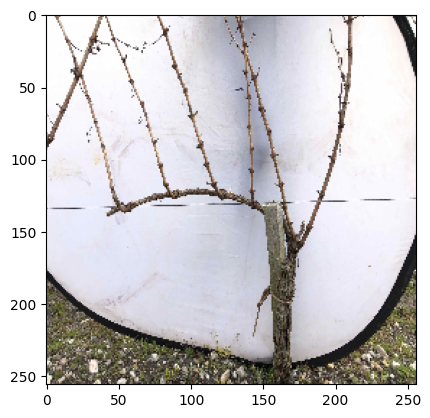

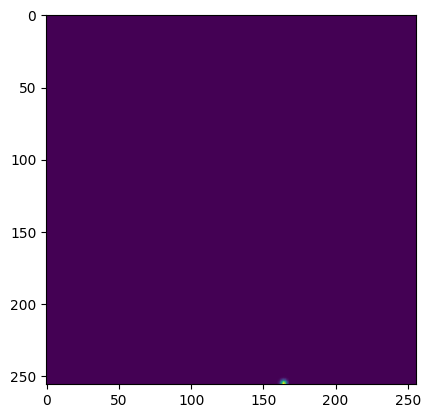

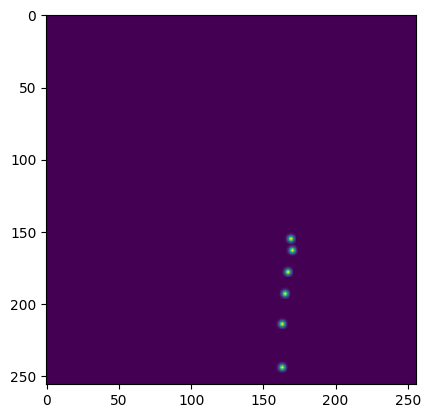

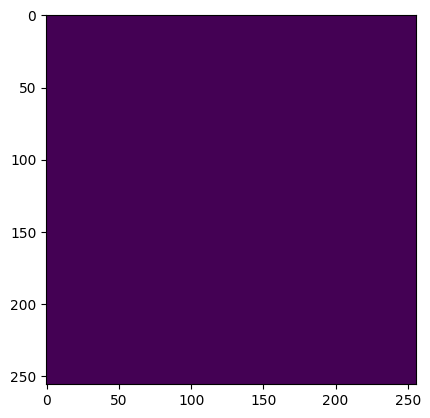

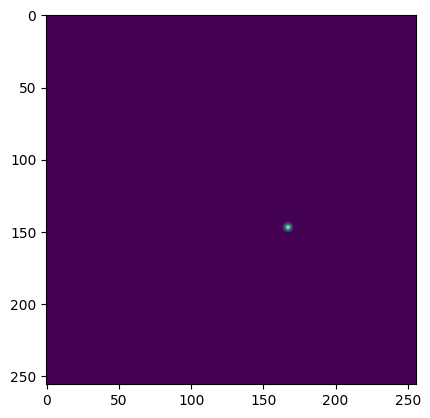

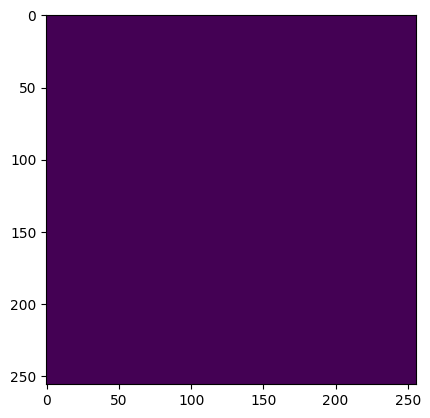

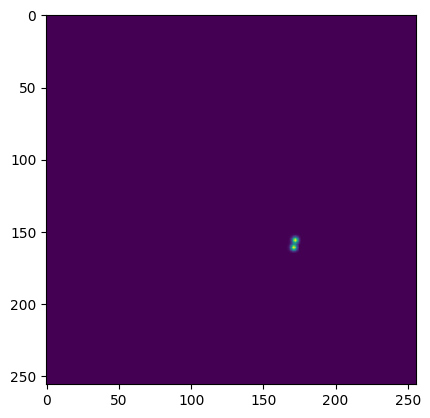

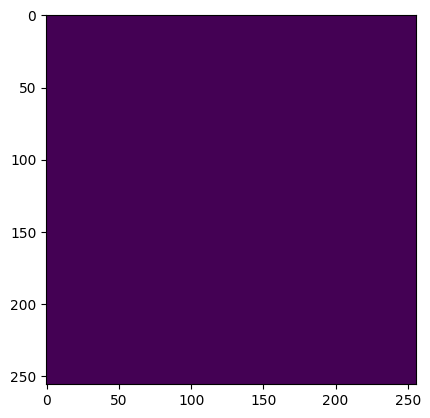

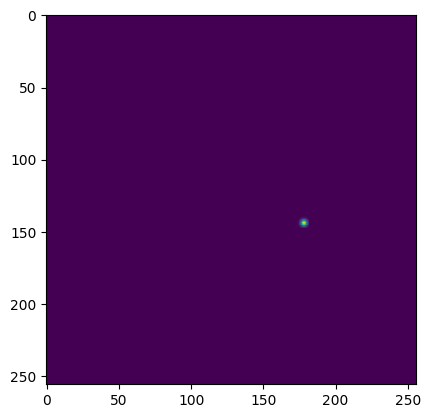

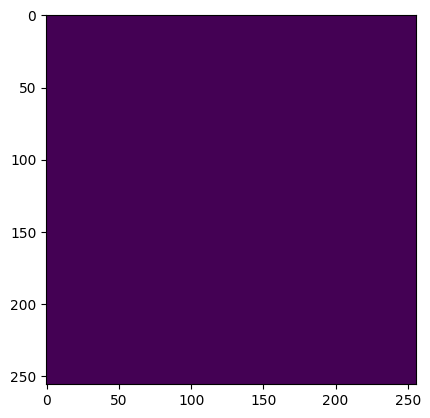

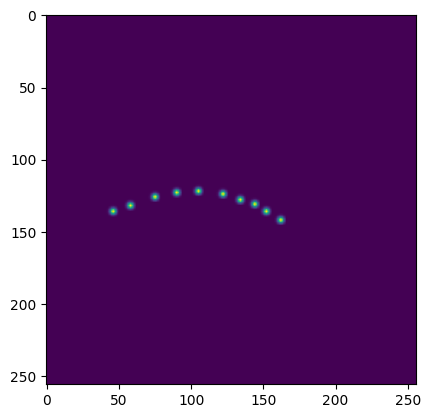

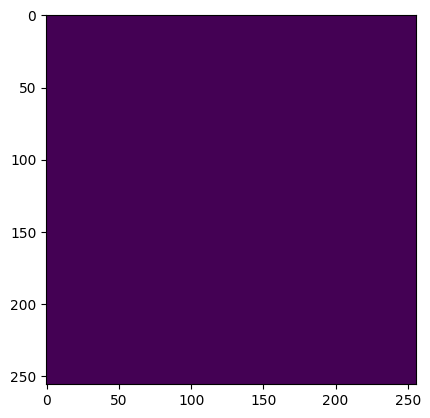

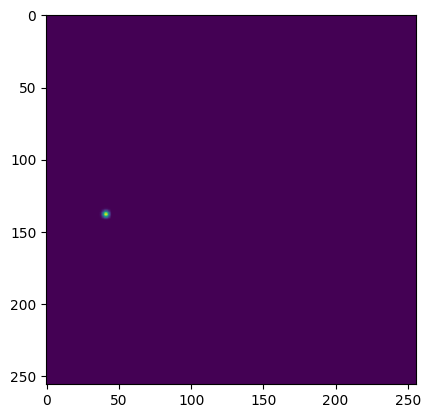

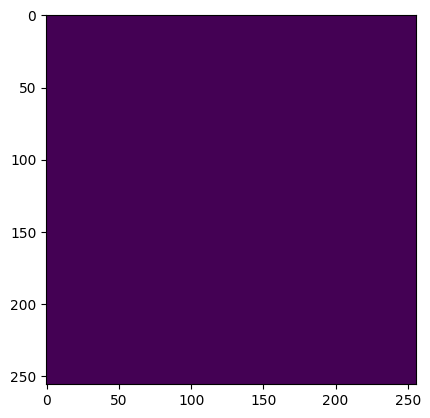

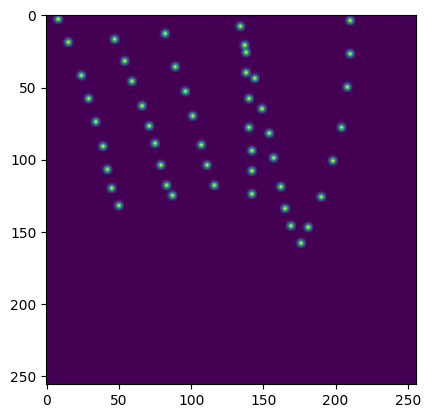

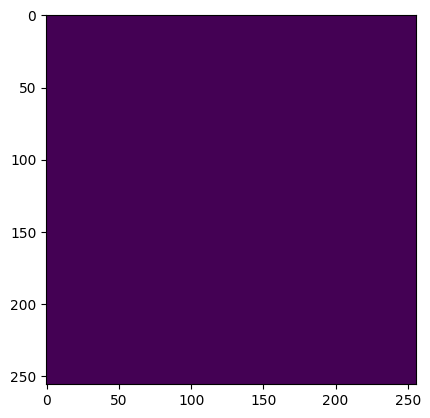

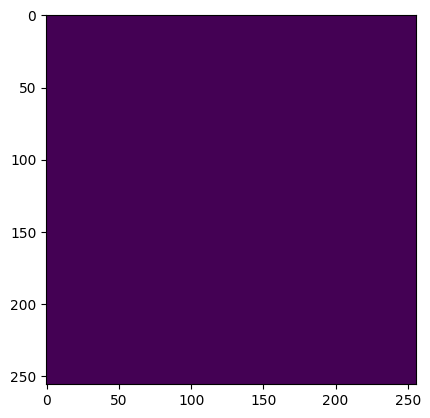

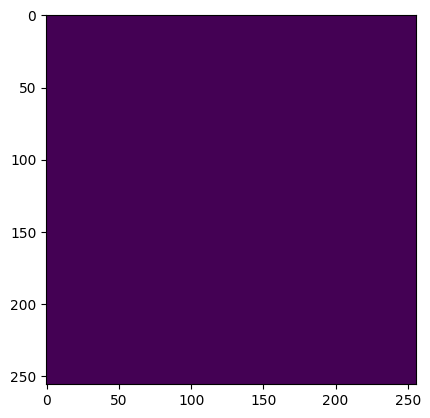

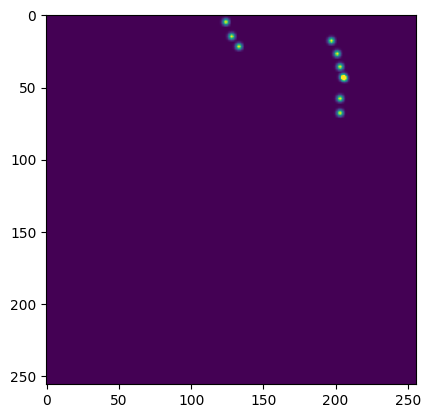

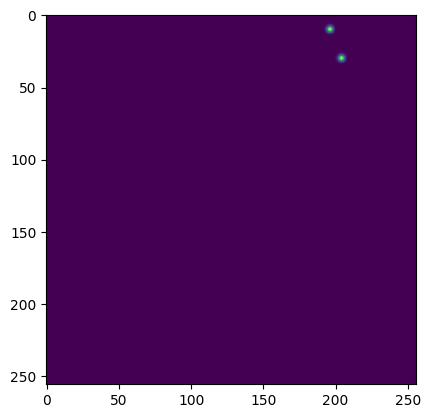

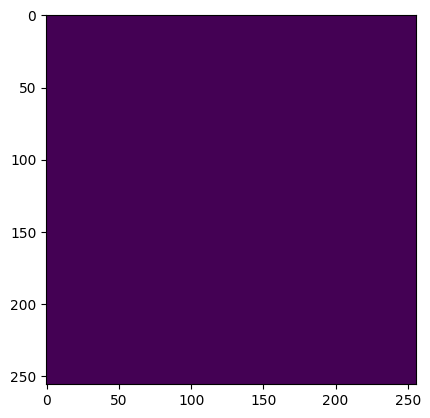

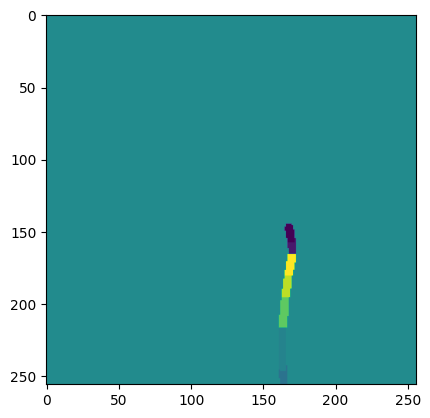

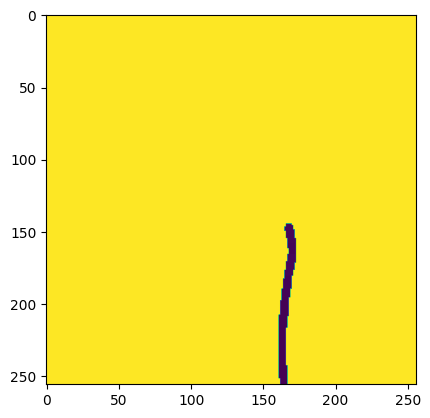

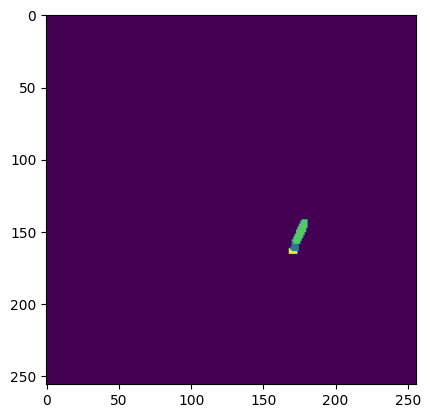

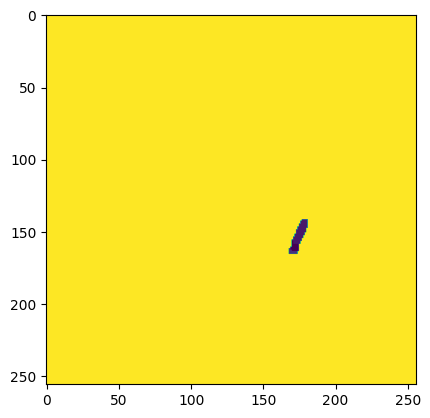

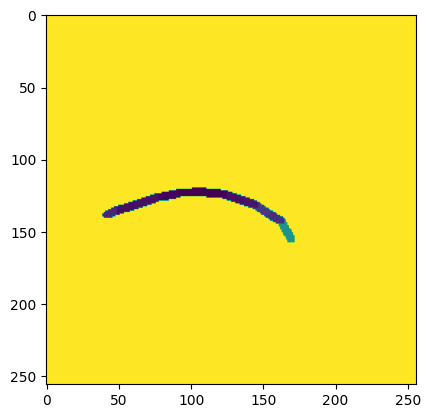

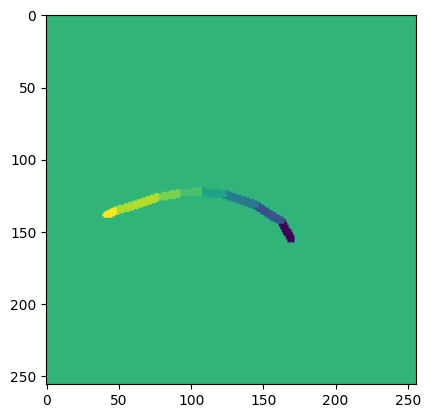

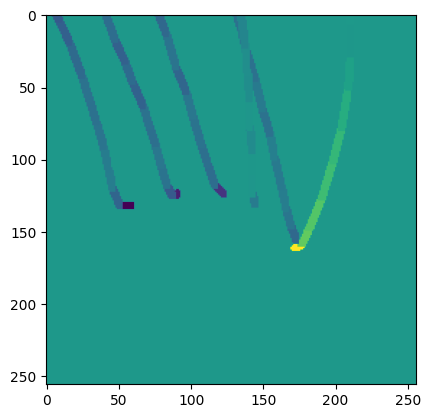

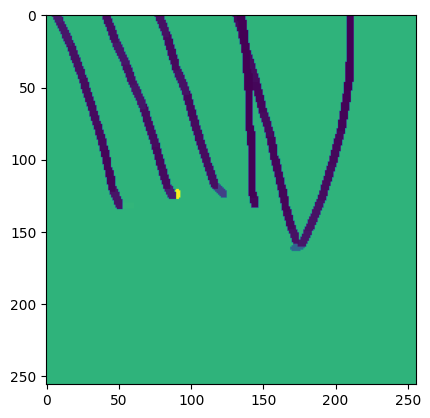

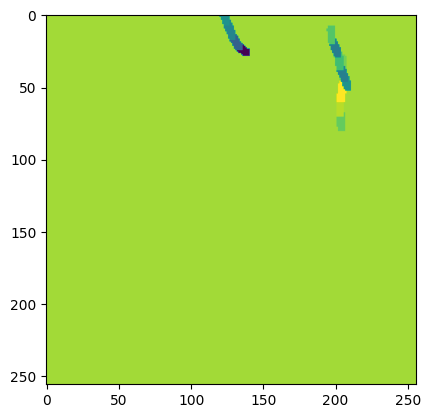

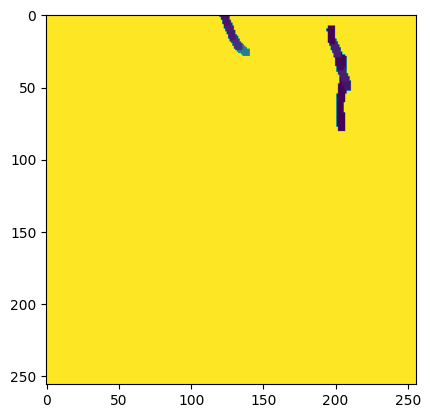

In [62]:
num_node_types = 4
num_branch_types = 5
sigma = 1.5

possible_parents = {
    'lateralShoot': ["lateralShoot", "shoot"],
    'shoot': ["shoot", "cane", "courson"],
    'cane': ["cane", "mainTrunk"],
    'courson': ["courson", "mainTrunk"],
    'mainTrunk': ["mainTrunk", "rootCrown"]
}

dataset = VineDataset('/kaggle/input/vinetdataset/3D2cut_Single_Guyot/01-TrainAndValidationSet', branch_types=branch_types, node_types=node_types)

for i in range(5):

    # print(dataset[i])
    
    image, M = dataset[i]


    plt.imshow(image)
    
    for j in range(30):
        plt.figure()
        plt.imshow(M[j, :, :])


    break
    total_nodes_extracted = dict()
    for bname, branch_type in branch_types.items():
        # Visualize heatmaps for branch type 0 and all node types
        for nname, node_type in node_types.items():
            # Extract nodes
            heatmap = heatmaps[branch_type, node_type]
            nodes_extracted = extract_node_coordinates(heatmap)
            # print(nodes_extracted)
            total_nodes_extracted[(bname, nname)] = nodes_extracted
    
    # print(total_nodes_extracted)    
    
    # Create a row of 3 subplots
    fig, axes = plt.subplots(5, 2, figsize=(40, 40))  # 1 row, 3 columns
    
    i=0
    for vector_field in vector_fields:
        # Visualize the x and y components of the vector field
        axes[i, 0].imshow(vector_field[:, :, 0]) # plotting X
        axes[i, 1].imshow(vector_field[:, :, 1]) # plotting Y
        i +=1
            
    graph = construct_resistivity_graph(total_nodes_extracted, vector_fields, possible_parents, np.inf)
    
    # extract root node
    root_node_cohord = total_nodes_extracted[('mainTrunk', 'rootCrown')][0]
    root_node = (root_node_cohord, ('mainTrunk', 'rootCrown'))
    
    # Estimate the tree structure
    tree_structure = grapevine_structure_estimation(graph, root_node)
    
    plot_graph_on_image(tree_structure, image=image, draw_resistivity=True)
    plt.figure()


## Training

In [71]:


# Residual Block 

class ResidualBlock(nn.Module):

    def __init__(self, in_channels):

        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1)

        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1)

        

        self.relu = nn.ReLU(inplace=True)

        

    def forward(self, x):

        residual = x

        out = self.relu(self.conv1(x))

        out = self.relu(self.conv2(out))

        out = self.conv3(out)

        out += residual  # Adding the shortcut connection

        out = self.relu(out)  # Final ReLU activation after addition

        return out



# Skip Connection Block

class SkipBlock(nn.Module):

    def __init__(self, in_channels):

        super(SkipBlock, self).__init__()

        self.block = ResidualBlock(in_channels)



    def forward(self, x):

        return self.block(x)



# Hourglass Module

class Hourglass(nn.Module):

    def __init__(self, depth, num_features):

        super(Hourglass, self).__init__()

        self.depth = depth

        self.down_blocks = nn.ModuleList([ResidualBlock(num_features // 2**(k)) for k in range(depth)])

        self.up_blocks = nn.ModuleList([ResidualBlock(num_features // 2**(k)) for k in range(depth)])

        self.skip_blocks = nn.ModuleList([SkipBlock(num_features // 2**(k) ) for k in range(depth)])



    def forward(self, x):

        down_features = []

        # Down-sampling pathway

        for i in range(self.depth):

            x = self.down_blocks[i](x)

            down_features.append(x)

            x = F.max_pool2d(x, kernel_size=2, stride=2)



        # Bottom layer (lowest resolution)

        x = self.down_blocks[-1](x)



        # Up-sampling pathway

        for i in reversed(range(self.depth)):

            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)

            x = self.up_blocks[i](x + down_features[i] + self.skip_blocks[i](down_features[i]))  # Adding skip connections



        return x

    

class FeatureExtraction(nn.Module):

    def __init__(self, in_channels, out_channels):

        super(FeatureExtraction, self).__init__()

        self.initial_conv = nn.Sequential(

            nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=2, padding=3),

            nn.InstanceNorm2d(out_channels),

            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            ResidualBlock(out_channels),

            ResidualBlock(out_channels)

        )



    def forward(self, x):

        return self.initial_conv(x)



# Define the Stacked Hourglass Network with two hourglass modules

class StackedHourglassNetwork(nn.Module):

    def __init__(self, in_channels, num_features, num_output_channels):

        super(StackedHourglassNetwork, self).__init__()

        self.feature_extractor = FeatureExtraction(in_channels, num_features)

        

        # Two hourglass modules in series

        self.hourglass1 = Hourglass(depth=5, num_features=num_features)

        self.hourglass2 = Hourglass(depth=5, num_features=num_features)



        # Output convolutions

        self.output_conv1 = nn.Conv2d(num_features, num_output_channels, kernel_size=1)



        # Merging layers between the hourglasses

        self.merge_conv = nn.Conv2d(num_output_channels, num_features, kernel_size=1)



    def forward(self, x):

        # x is the input image
        
        features = self.feature_extractor(x)

        

        # First hourglass

        hg1 = self.hourglass1(features)

        out1 = self.output_conv1(hg1)

        

        # Merge output of the first hourglass to feed into the second

        merged_features = features + self.merge_conv(out1)

        

        # Second hourglass

        hg2 = self.hourglass2(merged_features)

        output = hg2

        

        return output  # Final output



def stacked_hourglass_loss(predictions, ground_truth):

    out1, out2 = predictions  # predictions from each hourglass

    gt1, gt2 = ground_truth   # corresponding ground truth heatmaps



    # Calculate L2 loss for each hourglass output

    loss1 = F.mse_loss(out1, gt1)

    loss2 = F.mse_loss(out2, gt2)

    

    # Total loss as the sum of both losses

    total_loss = loss1 + loss2

    return total_loss


In [72]:

dataset = VineDataset('/kaggle/input/vinetdataset/3D2cut_Single_Guyot/01-TrainAndValidationSet', branch_types=branch_types, node_types=node_types)


# set the device to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = StackedHourglassNetwork(in_channels=3, num_features=256, num_output_channels=30).to(device)

criterion = stacked_hourglass_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

out = model(dataset[0][0])
print(out.shape)




# # Training loop
# for epoch in tqdm(range(386)):

#     print(f'Epoch {epoch}', end='\t')

#     for images, M in train_loader:

#         print(f'1')

#         images, heatmaps = images.to(device), heatmaps.to(device)

#         print(f'2')

#         optimizer.zero_grad()

#         outputs = model(images)

#         print(f'3')

#         loss = criterion(outputs, heatmaps)

#         print(f'4')

#         loss.backward()

#         print(f'5')

#         optimizer.step()

#         print(f'6')

#         print(f'Loss: {loss.item()}')

/kaggle/input/vinetdataset/3D2cut_Single_Guyot/01-TrainAndValidationSet/Set03_IMG_1172_annotation.json
torch.Size([20, 256, 256])
torch.Size([10, 256, 256])
torch.Size([30, 256, 256])


TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
